## Phase contrast imaging using multislice ptychography

In this tutorial notebook, we will reconstruct the electrostatic potential of a simulated "thick" STO sample using multislice ptychography.

### Downloads
* [13nm thick STO 4D-STEM dataset](https://drive.google.com/file/d/15LQsKLtrjcCzooEfPMhL9OJQTqV2EleT/view?usp=share_link)
* [[Optional] 20nm thick STO 4D-STEM dataset](https://drive.google.com/file/d/1kdPjT8fxjnRCvpIYU9d253GhvmKxJOBl/view?usp=share_link)
* [[Optional] 27nm thick STO 4D-STEM dataset](https://drive.google.com/file/d/1HalA_U-HC6KmV4PFu6c-rnAaOt0hrtQc/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

The 4D-STEM dataset used here was simulated in abTEM using the following parameters:
- Convergence angle: 20 mrad
- Accelerating voltage: 300 kV
- Probe aberrations: 100 A defocus
- Poisson noise: 10,000 $e/A^2$

Updated 2023 May 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import py4DSTEM
print(py4DSTEM.__version__)

0.14.0


# Load data, basic visualization

We'll use three different simulated datasets for STO [110] with increasing thicknesses. First, we load the one for a 13nm thick sample and plot the mean diffraction pattern:

In [2]:
file_path = 'data/'

In [3]:
dataset_13nm = py4DSTEM.read(file_path+"ptycho_STO-110_13nm.h5")
dataset_13nm.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.1237760874546576
             R_pixel_size:    0.5072051228477243
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

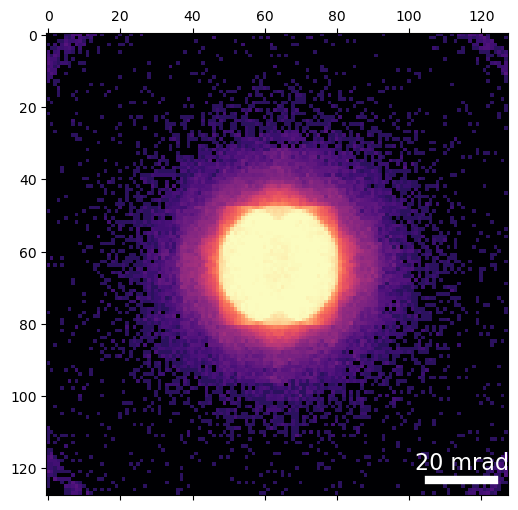

In [4]:
dataset_13nm.get_dp_mean()
py4DSTEM.show(
    dataset_13nm.tree("dp_mean"),
    cmap='magma',
    power=0.25,
    figsize=(6,6),
)

As we can see, the data is fairly noisy - with strong scattering inside the BF disk.

## Single-slice reconstruction

First, let's see how well single-slice reconstruction fares on this dataset:

Best fit rotation = 0.0 degrees.
No need to transpose diffraction intensities.


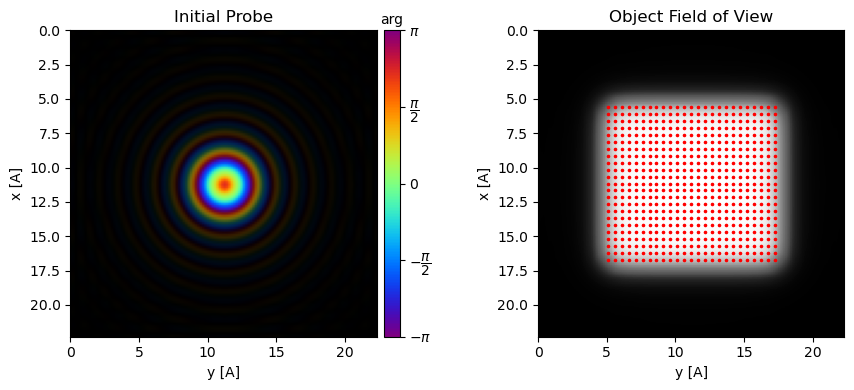

In [6]:
ptycho_13nm = py4DSTEM.process.phase.PtychographicReconstruction(
    dataset_13nm,
    verbose=True,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    device='gpu',
    #object_type='potential',
    object_padding_px=(0,0),
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.23 iter/s]


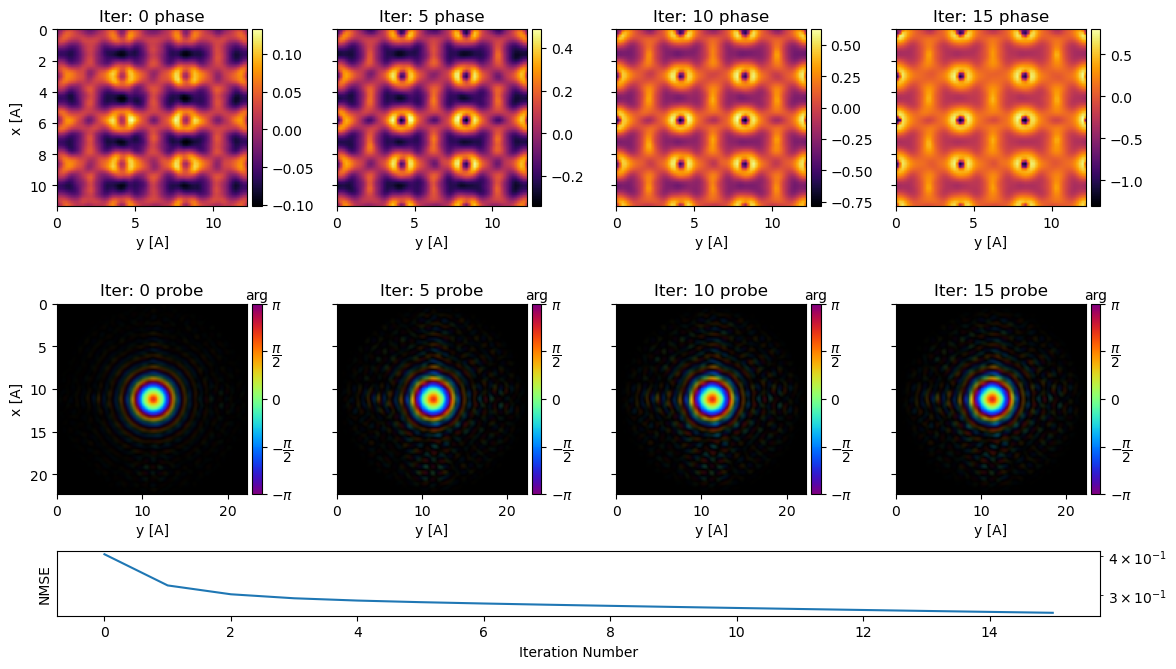

In [7]:
ptycho_13nm = ptycho_13nm.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    step_size=0.5,
    q_lowpass=2,
    #switch_object_iter=8,
).visualize(
    cbar=True,
    iterations_grid = 'auto'
)

The final reconstructed object is not very good at all..  This is partly because of phase-wrapping issues, and can be somewhat remedied using more iterations at smaller `step_size`, as well as initial pure-phase object iterations using `pure_phase_object_iter`, but ultimately this illustrates the breakdown of single-slice ptychography for strongly-scattering objects.

Additionally, the probe is starting to change from a defocused to a focused-geometry. What the algorithm appears to be picking up on is that it can reproduce the measured intensities better if it emulates "channeling".

## Multi-slice ptychography

Let's see if multi-slice ptychography can perform better.
We'll use slices of equal thickness equal to 18 layers of ST0 [110], or ~3.5nm.

In [8]:
slice_thicknesses = 33.4755

For our 13nm thick dataset we therefore need 4 slices:

In [9]:
slice_thicknesses*4

133.902

Best fit rotation = 0.0 degrees.
No need to transpose diffraction intensities.


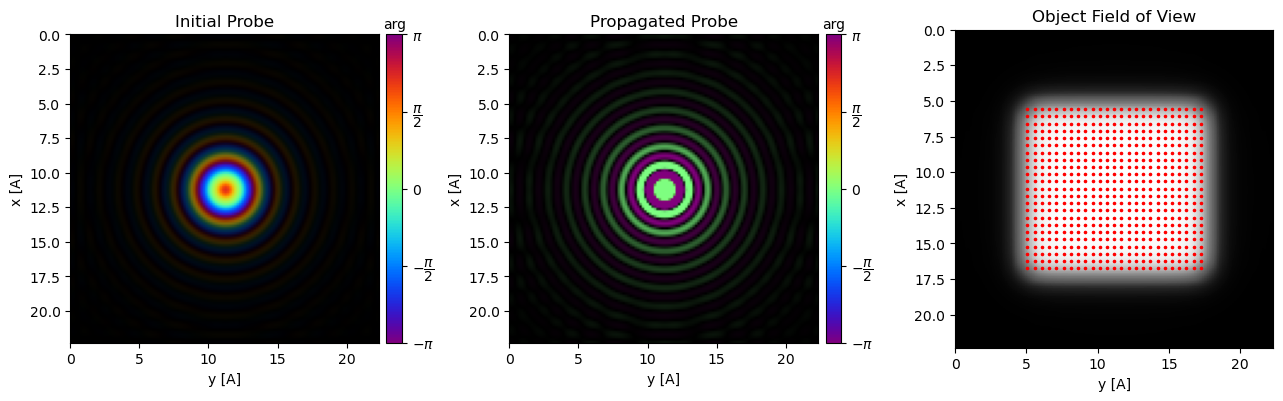

In [10]:
ms_ptycho_13nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    dataset_13nm,
    num_slices=4,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(0,0),
    device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

Performing 16 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.90 iter/s]


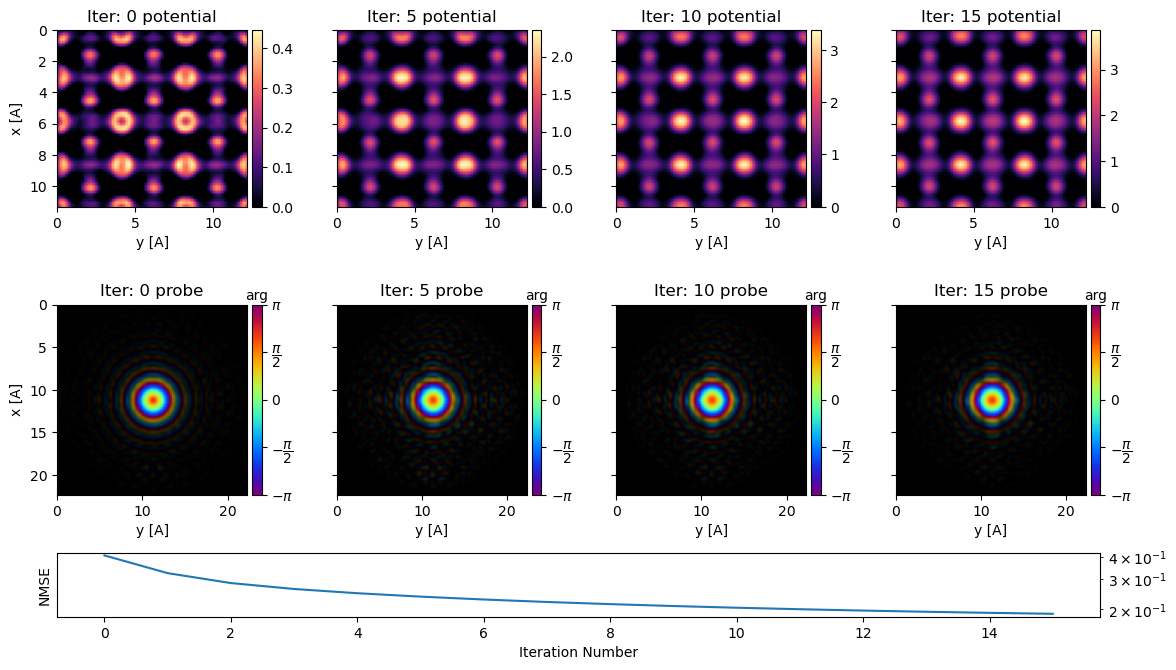

In [11]:
ms_ptycho_13nm = ms_ptycho_13nm.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    step_size=0.5,
    q_lowpass=2,
).visualize(
    cbar=True,
    iterations_grid = 'auto'
)

Indeed, not only is the object is much better reconstructed but the probe looks a lot more physical with the same order of defocus.

Let's compare the complex probes in Fourier space:

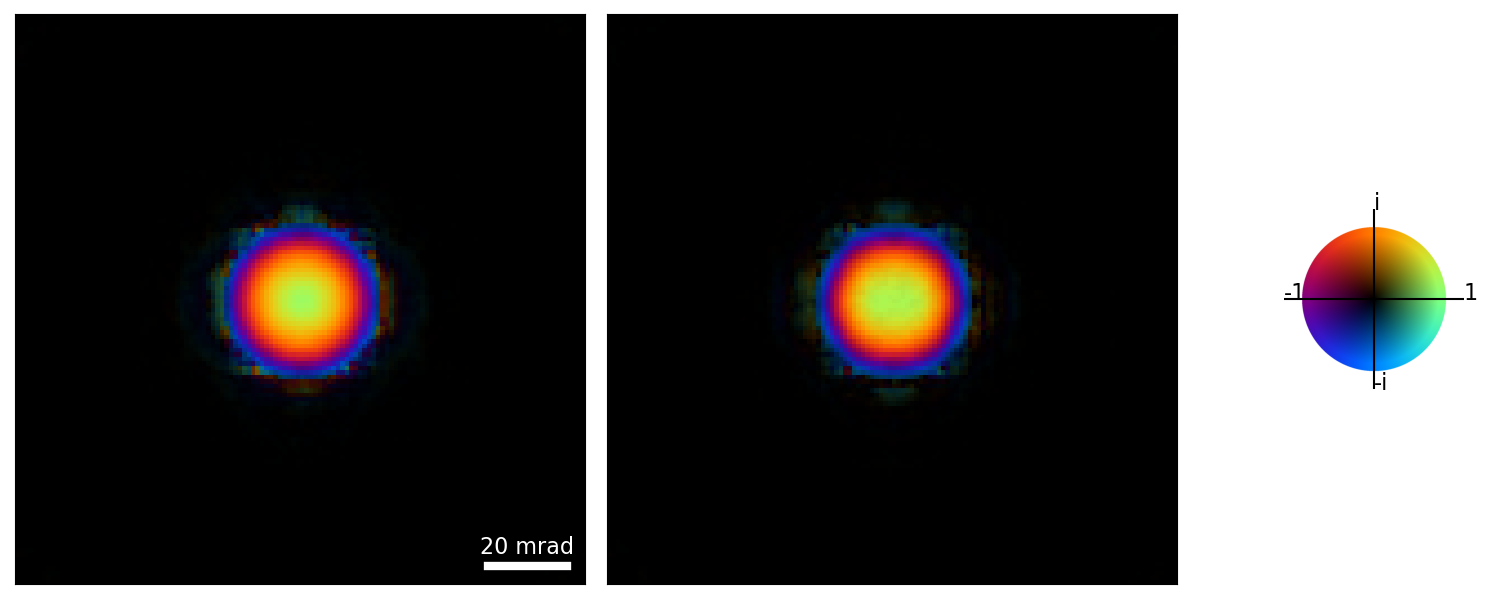

In [12]:
py4DSTEM.visualize.show_complex(
    [
        ptycho_13nm.probe_fourier,
        ms_ptycho_13nm.probe_fourier
    ],
    scalebar=True,
    pixelsize=ms_ptycho_13nm.angular_sampling[0],
    pixelunits="mrad",
    ticks=False,
)

As we can see, the single-slice reconstruction is starting to decrease its defocus

### [Optional] Linearity of multislice-ptychography?

It's also of interest to see how far we can push this, by investigating thicker samples with more slices. Ideally, the phase should be linear and thus our algorith should reconstruct equally well for thicker samples.  
_Note:_ The following cells will take ~3 mins each using `device='cpu'`.

In [13]:
dataset_20nm = py4DSTEM.read(file_path+"ptycho_STO-110_20nm.h5")
ms_ptycho_20nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    dataset_20nm,
    num_slices=6,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(0,0),
    device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    step_size=0.5,
    q_lowpass=2,
)

Best fit rotation = 0.0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.10 iter/s]


In [14]:
dataset_27nm = py4DSTEM.read(file_path+"ptycho_STO-110_27nm.h5")
ms_ptycho_27nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    dataset_27nm,
    num_slices=8,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(0,0),
    device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    step_size=0.5,
    q_lowpass=2,
)

Best fit rotation = 0.0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.13 iter/s]


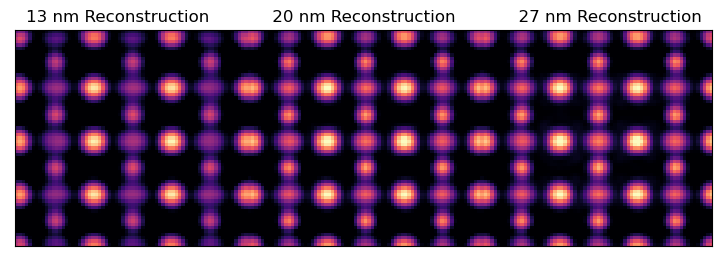

In [15]:
py4DSTEM.show(
    np.hstack((
        ms_ptycho_13nm._crop_rotate_object_fov(ms_ptycho_13nm.object.sum(0)),
        ms_ptycho_20nm._crop_rotate_object_fov(ms_ptycho_20nm.object.sum(0)),
        ms_ptycho_27nm._crop_rotate_object_fov(ms_ptycho_27nm.object.sum(0))
    )),
    cmap='magma',
    vmin=0.333,
    vmax=0.999,
    ticks=False,
    figsize=(9,3),
    title="13 nm Reconstruction\t\t20 nm Reconstruction\t\t27 nm Reconstruction".expandtabs()
)

Indeed, as we can see the reconstructions are mostly linear for the experimental conditions we have used here.